<a href="https://colab.research.google.com/github/yohan-th/ft_sommelier/blob/master/ft_sommelier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import random
import copy
import math

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/resources')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **V.1  Exploring the green reds**

Wine Quality Data Set of "Vinho Verde" red wine.

I didn't taste it, but we will trust expert's judgment.

https://archive.ics.uci.edu/ml/datasets/wine+quality

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 

In [0]:
wine_data = pd.read_csv("winequality-red.csv", delimiter=';')#, nrows=5)
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [0]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
  df = pd.read_csv(wine_data, delimiter=';')#, usecols=[0, 1, 11], nrows=100)
  n_rows, n_colmn = df.shape
  
  fig, ax = plt.subplots(n_colmn, n_colmn, figsize=(40, 40))
  for axes in ax.flat:
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
  plt.subplots_adjust(wspace=0.0, hspace=0.0)

  for i in range(n_colmn):
    for j in range(n_colmn):
      if i == j:
        ax[i, j].text(0.5, 0.5, df.columns[i], ha='center', size='xx-large', weight='bold')
      else:
        color = ['green' if k >= good_threshold else 'red' for k in df['quality']]
        size = [20 if k >= good_threshold else 20 if k <= bad_threshold else 0 for k in df['quality']]
        ax[i,j].scatter(df[df.columns[i]], df[df.columns[j]], alpha=0.30, s=size, c=color)

  if save_plot == True:
    plt.savefig('./redwinde_plot.png')

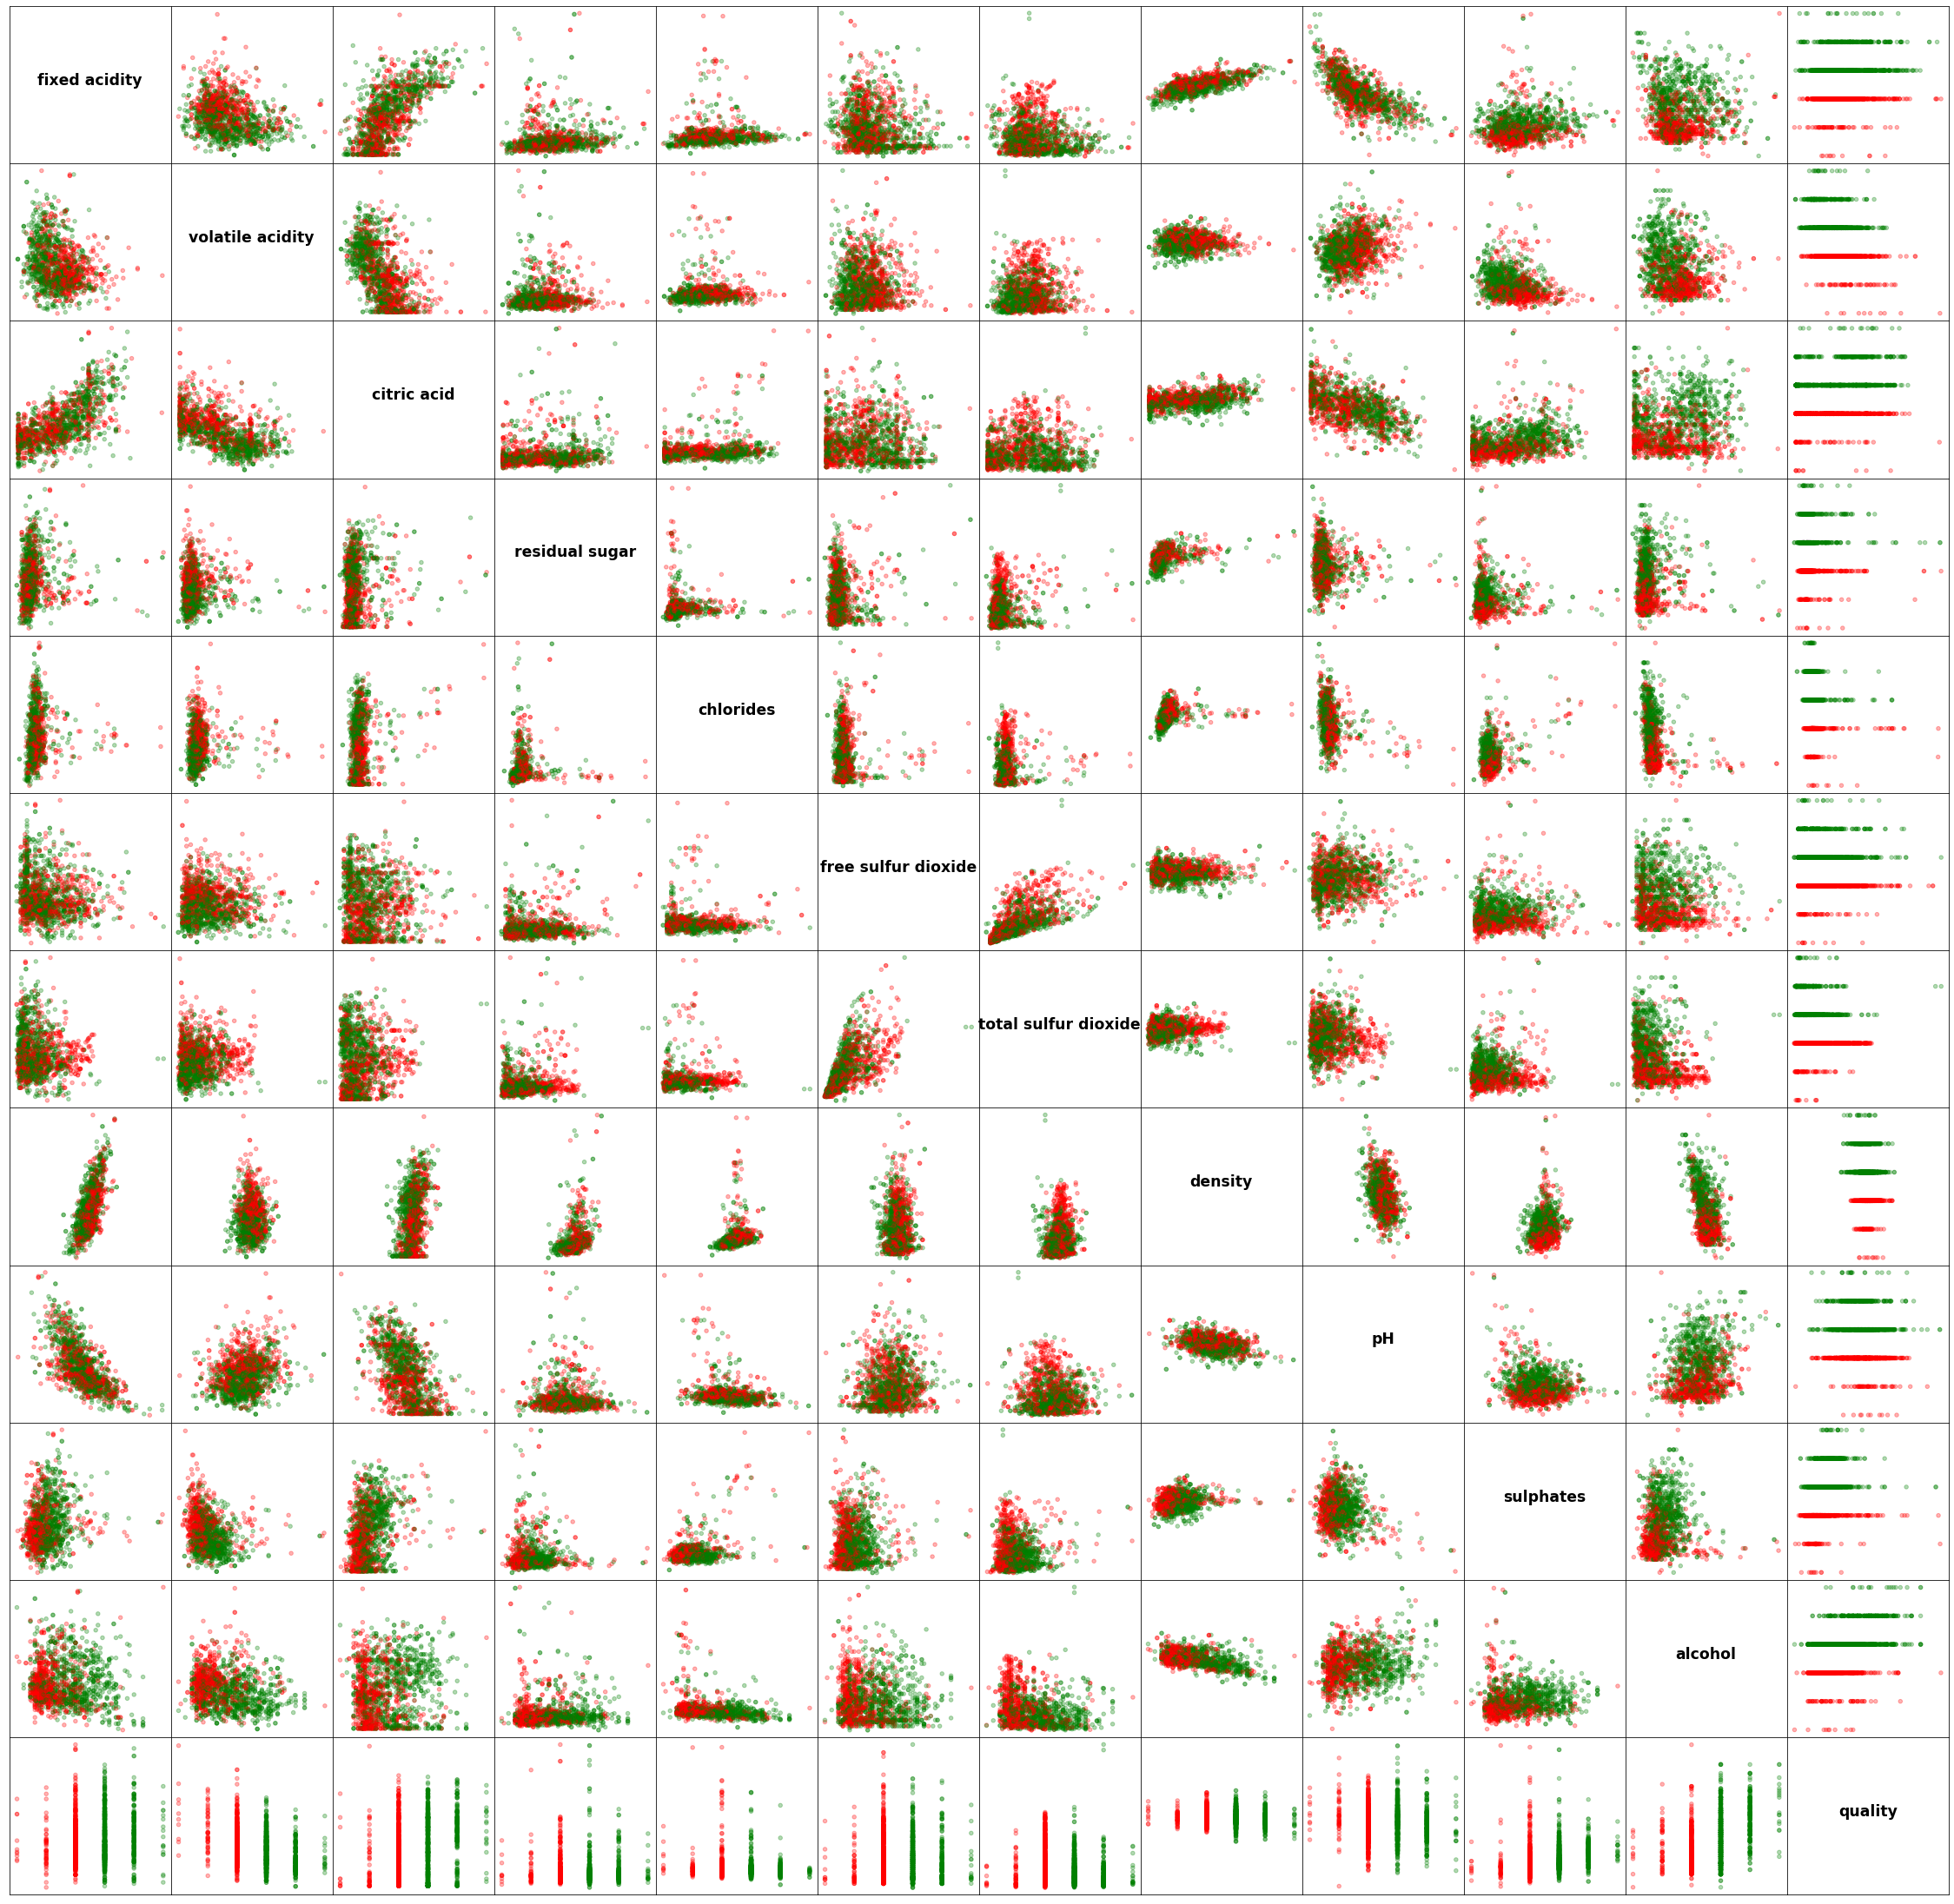

In [0]:
plot_scatter_matrix("winequality-red.csv", 6, 5, False)

The graphic shows the quality of wine (green=good & red=bad) in relation between 2 wine's attributes. **Most of plots don't show a distinct difference** between good and bad wine except attribute Sulphates and Alcohol where red and green dot seems to be separate.

We conclude attributes **sulphates** and **alcohol** is a good reference to judge if wine is good or not.


---




# **V.2  Learning to perceptron**

We will classify the wines as “good” or “bad” based on only chemical attributes with **perceptron algorithm**.
As concluded in V1 we choose **sulphates and alcohol attributes**.

In [16]:
wine_data = pd.read_csv("winequality-red.csv", delimiter=';')
wine_data = wine_data.assign(drunkable=pd.Series(wine_data['quality'] >= 6))
slct_data = wine_data[['pH', 'alcohol', 'quality', 'drunkable']]
slct_data = slct_data[(slct_data.quality >= 8) | (slct_data.quality <= 3)].reset_index()
slct_data['drunkable'] = slct_data['drunkable'].map({True:1, False:0})
print(f"First a quick look of our very good wines (quality >= 8) and very bad (quality <= 3)\n\n{slct_data}")

First a quick look of our very good wines (quality >= 8) and very bad (quality <= 3)

    index    pH  alcohol  quality  drunkable
0     267  3.35    12.80        8          1
1     278  3.23    12.60        8          1
2     390  3.56    12.90        8          1
3     440  2.88     9.80        8          1
4     455  3.22    13.40        8          1
5     459  3.25     9.00        3          0
6     481  3.15    11.70        8          1
7     495  3.15    11.00        8          1
8     498  3.15    11.00        8          1
9     517  3.16     8.40        3          0
10    588  3.72    14.00        8          1
11    690  3.63    10.70        3          0
12    828  3.46    12.70        8          1
13    832  3.38     9.90        3          0
14    899  3.48    11.00        3          0
15   1061  3.21    12.50        8          1
16   1090  2.98    11.80        8          1
17   1120  3.20    13.10        8          1
18   1202  3.35    11.70        8          1
19   1269  3.5

[**PERCEPTRON**](https://www.rootandadmin.com/index.php/2019/06/03/the-perceptron-with-python/comment-page-1/)

1.   PRE-ACTIVATION FUNCTION

In [0]:
def pre_activation(features:list, weights:list, bias:int):
    # somme pondérées
    weighted_sum = 0
    
    for (feature, weight) in zip(features, weights):
        weighted_sum += feature * weight
    weighted_sum += bias
    
    return weighted_sum

2. ACTIVATION FUNCTION

In [0]:
# heaviside step activation function
def activation_function(value:int):
    # le seuil
    threshold = 0
    
    # etat du neurone : sortie y
    isActivated = bool
    
    # etat du neurone
    if value >= threshold:
        isActivated = True
    else:
        isActivated = False
        
    return int(isActivated) # 0/1

3. PERCEPTRON ALGORITHME

In [0]:
def training(lr:int, dataset:list, targets:list, max_epoch:int):
    # initialisations des poids synaptiques (parametres) random
    bias = random.random()
    weights = [random.random()] * len(dataset[0])
 
    # ITERATION SUR LES DONNEES
    convergence = False
    epoch = 0
    ret = []
    
    while not convergence:
        predictions = []
        for index, features in enumerate(dataset):
            pre_act = pre_activation(features=features, weights=weights, bias=bias)
            prediction = activation_function(pre_act)
            
            target = targets[index]
            predictions.append(prediction)
            
            # COST EVALUATION
            error = lr * (target - prediction)
            bias += error

            # Calculate new weight
            for i in range(len(weights)):
              weights[i] += error * features[i]
        
        nb_error = 0
        for index, pred in enumerate(predictions):
            if pred != targets[index]:
                nb_error += 1

        #mean_error = mean_error / len(predictions)

        # TEST DE CONVERGENCE
        if predictions == targets:
            convergence = True
            print("CONVERGENCE ! No error left")
        elif epoch == max_epoch:
            print(f"Max epoch reached : {epoch} epochs")
            convergence = True
        #print(f"ITERATION : {epoch} Error : {nb_error}")
        
        ret.append((epoch, nb_error, weights, bias))
        epoch += 1

    return ret

In [20]:
dataset = slct_data.loc[:, ['pH', 'alcohol']]
atr1 = list(dataset['pH'])
atr2 = list(dataset['alcohol'])
dataset = list(map(list, zip(atr1, atr2)))

labels = list(slct_data['drunkable'])

learning_rate = 0.01
train = training(learning_rate, dataset, labels, 14000)
print("[(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), . . . ]")
print(f"{train[0]}\n...\n{train[-1]}")

CONVERGENCE ! No error left
[(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), . . . ]
(0, 9, [-7.23929802501272, 1.728701974981975], 0.07600048680498632)
...
(13176, 0, [-7.23929802501272, 1.728701974981975], 6.0960004868049005)


After few epochs our perceptron founds **correct values of weights and bias** for a boundary decision between good and bad wine with only pH and alcohol attributes.

**Generate Plots**

To confirm our perceptron algorithme works we need to show plot of decision boundary with good and bad wine on each side

In [0]:
def draw_decision_boundary(axes, performance, wine_data, epoch):
    x_min = wine_data.loc[:, 'alcohol'].min() - 0.2
    x_max = wine_data.loc[:, 'alcohol'].max() + 0.2
    y_min = wine_data.loc[:, 'pH'].min()- 0.2
    y_max = wine_data.loc[:, 'pH'].max()+ 0.2
    axes[1].set_title('Decision boundary on epoch: {}'.format(epoch))
    axes[1].set_ylabel(wine_data.columns[0])
    axes[1].set_ylim([y_min, y_max])
    axes[1].set_xlabel(wine_data.columns[1])
    axes[1].set_xlim([x_min, x_max])
    
    w2, w1 = performance[epoch][2]
    b = performance[epoch][3]
    slope = -w1/w2
    intercept = -b/w2
    x_coords = range(int(x_min) - 1, int(x_max) + 2)

    y_coords = [i * slope + intercept for i in x_coords]

    line = axes[1].plot(x_coords, y_coords, 'b--', label='Decision boundary')
    axes[1].fill_between(x_coords, y_coords, y_min, color='#90EE90')
    axes[1].fill_between(x_coords, y_coords, y_max, color='#FA8072')
    
    return line

def draw_scatter(axes, wine_data, good_thresh, bad_thresh):
    good_wines = wine_data[(wine_data['quality'] >= good_thresh)]
    bad_wines = wine_data[(wine_data['quality'] <= bad_thresh)]

    axes[1].scatter(good_wines.loc[:, 'alcohol'], good_wines.loc[:, 'pH'],
                    c=['g'], label='good wines (>= {} score)'.format(good_thresh))
    axes[1].scatter(bad_wines.loc[:, 'alcohol'], bad_wines.loc[:, 'pH'],
                    c=['r'], label='bad wines (<= {} score)'.format(bad_thresh))


def plot_performance(performance:list, wine_data:list, good_thresh:int, bad_thresh:int, epoch=-1, save_plot=False):
  
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

  #Error plot
  all_epoch = [elem[0] for elem in performance]
  all_error = [elem[1] for elem in performance]
  ax[0].plot(all_epoch, all_error)
  ax[0].set_title('Errors as a function of epoch')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Errors')

  #Boundary decision plot
  if epoch == -1:
      epoch = len(performance) - 1
  line = draw_decision_boundary(ax, performance, wine_data, epoch)
  draw_scatter(ax, wine_data, good_thresh, bad_thresh)
  ax[1].legend(bbox_to_anchor=(1, 1))

  if save_plot == True:
    plt.savefig('./performance_plot.png')



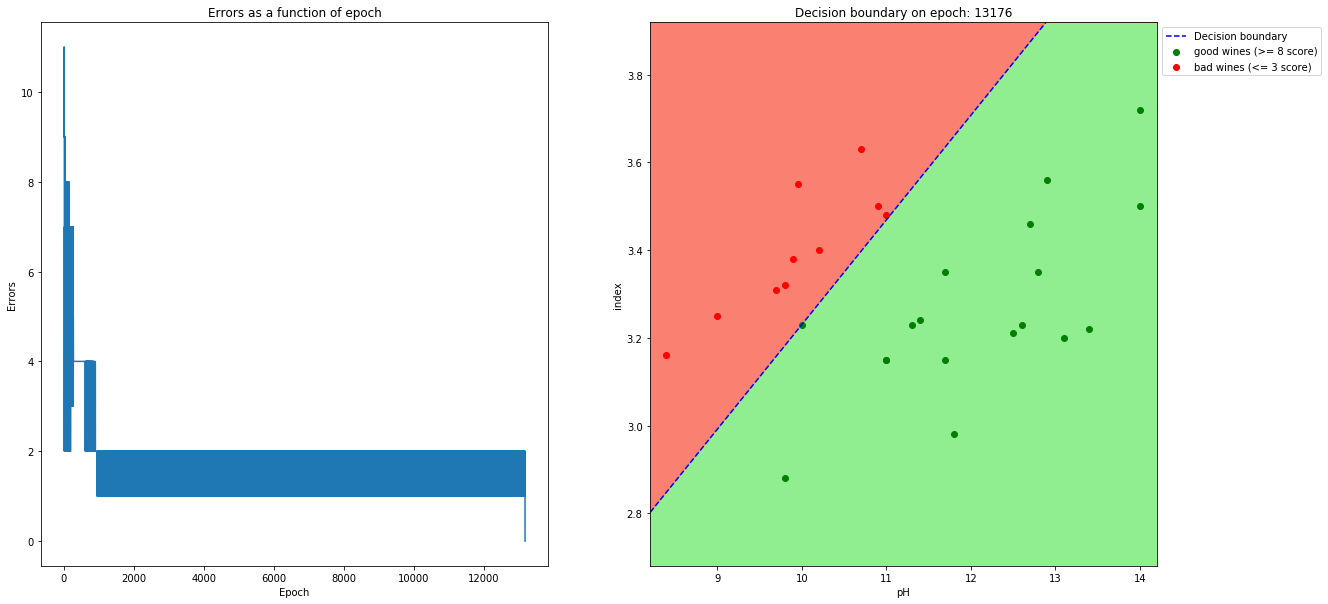

In [22]:
plot_performance(train, slct_data, 8, 3)

The Errors as function plot shows that our perceptron have **difficulties to find good weights and bias** with 2 last errors but at the end we have correct boundary decision between good and bad wine : green dots are on the green area and red dots are in red area.

To avoid this difficulties we will normalized pH and alcohol values to have common scale and optimize our further analysis. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

In [23]:
def normalize_data(series):
    return (series - series.mean()) / (series.max() - series.min())

cpy_slct_data = copy.deepcopy(slct_data)

cpy_slct_data['pH'] = normalize_data(cpy_slct_data['pH'])
cpy_slct_data['alcohol'] = normalize_data(cpy_slct_data['alcohol'])

print(f"New data normalized\n\n{cpy_slct_data}\n")

atr1 = list(cpy_slct_data['pH'])
atr2 = list(cpy_slct_data['alcohol'])
dataset_normalized = list(map(list, zip(atr1, atr2)))

labels = list(slct_data['drunkable'])

New data normalized

    index        pH   alcohol  quality  drunkable
0     267  0.042942  0.262436        8          1
1     278 -0.099915  0.226722        8          1
2     390  0.292942  0.280293        8          1
3     440 -0.516582 -0.273278        8          1
4     455 -0.111820  0.369579        8          1
5     459 -0.076105 -0.416135        3          0
6     481 -0.195153  0.066008        8          1
7     495 -0.195153 -0.058992        8          1
8     498 -0.195153 -0.058992        8          1
9     517 -0.183248 -0.523278        3          0
10    588  0.483418  0.476722        8          1
11    690  0.376276 -0.112564        3          0
12    828  0.173895  0.244579        8          1
13    832  0.078656 -0.255421        3          0
14    899  0.197704 -0.058992        3          0
15   1061 -0.123724  0.208865        8          1
16   1090 -0.397534  0.083865        8          1
17   1120 -0.135629  0.316008        8          1
18   1202  0.042942  0.066008

In [24]:
learning_rate = 0.01
train_norm = training(learning_rate, dataset_normalized, labels, 100)
print("[(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), . . . ]")
print(f"{train_norm[0]}\n...\n{train_norm[-1]}")

CONVERGENCE ! No error left
[(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), . . . ]
(0, 9, [-0.20600513088727593, 0.28689665482700955], 0.09789524431207212)
...
(71, 0, [-0.20600513088727593, 0.28689665482700955], 0.047895244312072136)


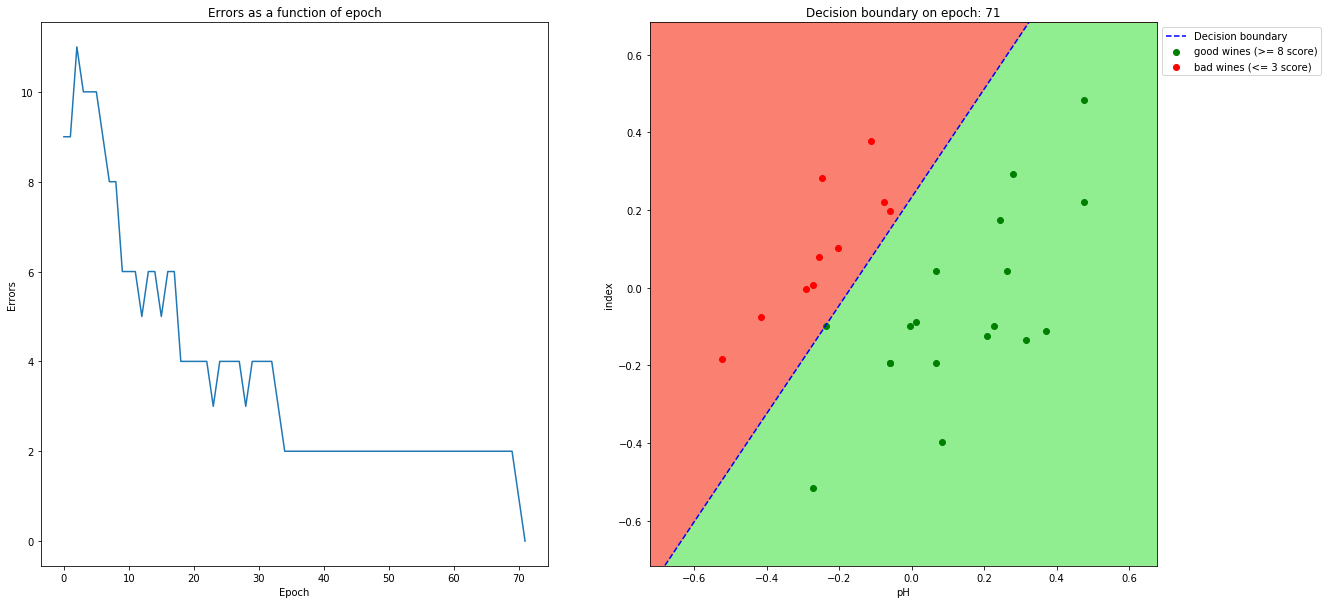

In [25]:
plot_performance(train_norm, cpy_slct_data, 8, 3)

# V3. Learning ADALINE (Adaptive Linear Neuron)

We will classify the wines as “good” or “bad” **based on only chemical attributes** with ADALINE algorithm. As concluded in V1 we choose sulphates and alcohol attributes. This time we will distinguish **wines with a score of 4 and lower, and wines with a score of 7 and higher**.

In [4]:
wine_data = pd.read_csv("winequality-red.csv", delimiter=';')
wine_data = wine_data.assign(drunkable=pd.Series(wine_data['quality'] >= 6))
slct_data = wine_data[['pH', 'alcohol', 'quality', 'drunkable']]
slct_data = slct_data[(slct_data.quality >= 7) | (slct_data.quality <= 4)].reset_index()
slct_data['drunkable'] = slct_data['drunkable'].map({True:1, False:0})
print(f"First a quick look of our good wines (quality >= 7) and bad (quality <= 4)\n\n{slct_data}")

First a quick look of our good wines (quality >= 7) and bad (quality <= 4)

     index    pH  alcohol  quality  drunkable
0        7  3.39    10.00        7          1
1        8  3.36     9.50        7          1
2       16  3.30    10.50        7          1
3       18  3.38     9.00        4          0
4       37  3.23     9.70        7          1
..     ...   ...      ...      ...        ...
275   1541  3.40    10.90        7          1
276   1544  3.17    11.20        7          1
277   1549  3.24    11.40        8          1
278   1555  3.44    10.55        7          1
279   1584  3.29    11.60        7          1

[280 rows x 5 columns]


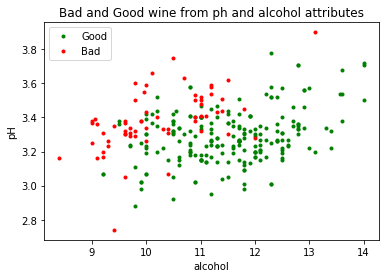

In [5]:
good_wines = slct_data[(slct_data['quality'] >= 7)]
bad_wines = slct_data[(slct_data['quality'] <= 4)]

# Plot
fig, ax = plt.subplots()
ax.plot(good_wines.loc[:, 'alcohol'], good_wines.loc[:, 'pH'], c='g', marker='o', linestyle='', ms=3, label="Good")
ax.plot(bad_wines.loc[:, 'alcohol'], bad_wines.loc[:, 'pH'], c='r', marker='o', linestyle='', ms=3, label="Bad")
ax.set_title('Bad and Good wine from ph and alcohol attributes')
ax.set_xlabel('alcohol')
ax.set_ylabel('pH')
ax.legend()


We see that good and bad wines are not clearly seperate. Single layer perceptrons are only capable of learning linearly so our perceptron can't distinguish good and bad wine with bondary decision. We need to use ADALINE algorithm.



> [**ADALINE**](https://www.bogotobogo.com/python/scikit-learn/Single-Layer-Neural-Network-Adaptive-Linear-Neuron.php)



In [0]:
def normalize_data(series):
    return (series - series.mean()) / (series.max() - series.min())

def ft_dot(a, b):
    result = 0
    for i in range(len(a)):
        result += a[i] * b[i]
    return result

In [0]:
class Adaline(object):

    def __init__(self, lr):
        self.W = []
        self.bias = 0
        self.lr = lr
        self.performance = []

    def _pre_activation(self, X:list):
        # somme pondérées
        weighted_sum = 0
        for (xi, wi) in zip(X, self.W):
          weighted_sum += xi * wi
        return weighted_sum + self.bias

    def _activation(self, X:list):
        # linear activation function
        pre_activation = self._pre_activation(X)
        return 1 / (1 + math.exp(-pre_activation))
    
    def _predict(self, X):
        return 1 if self._activation(X) > 0.5 else 0
    
    def _eval_epoch(self, X, y, epoch):
        nb_error = 0
        for xi, yi in zip(X, y):
            nb_error += int(self._predict(xi) != int(yi))
        return nb_error
    
    def _train_epoch(self, X, y, epoch):
        epoch_errors = []

        for xi, yi in zip(X, y):
            error = yi - self._activation(xi)
            epoch_errors.append(error)

        self.bias += self.lr * sum(epoch_errors)
        self.W += self.lr * ft_dot(X, epoch_errors)

        nb_error = self._eval_epoch(X, y, epoch)
        #print('Epoch {}, {} errors'.format(epoch, nb_error))

        self.performance.append((epoch, nb_error, self.W, self.bias))
        return nb_error
    
    def train(self, X, y, max_epochs):

        # initialisations des poids synaptiques (parametres) random
        self.bias = random.random()
        self.W = [random.random()] * len(X[0])

        epoch = 0
        while True:
            epoch_nb_errors = self._train_epoch(X, y, epoch)
            epoch += 1
            if epoch == max_epochs:
                break
            elif epoch_nb_errors == 0:
                break

        return self.performance

In [12]:
cpy_slct_data = copy.deepcopy(slct_data)

cpy_slct_data['pH'] = normalize_data(cpy_slct_data['pH'])
cpy_slct_data['alcohol'] = normalize_data(cpy_slct_data['alcohol'])

X = cpy_slct_data.loc[:, ['pH', 'alcohol']]
Y = cpy_slct_data['drunkable'].values

ada = Adaline(lr = 0.08)
train_adaline = ada.train(X.values, Y, 100)
print(train_adaline[0])
print("...")
print(train_adaline[-1])

(0, 63, array([-11.04282252,  12.33346689]), 4.8422618311925)
...
(99, 49, array([-11.04282252,  12.33346689]), 1.5823156139085306)
